# **Sentiment Analysis**
---


## **Introduction**
The aim of this notebook is to explain Sentiment Analysis' concepts step-by-step, starting from the preprocessing steps to the metrics for the evaluation of the performance of a machine learning model. 

* All **preprocessing steps** are explained and applied in order to build a function that could preprocess some text. 
* Then, it's applied the process so called **feature extraction** in order to vectorize our text, given as input to the considered machine learning model. 
* As feature extraction models, we consider **TF-IDF Vectorization** and **Word2Vec**, while as ML models, we consider **Logistic Regression** and **Naive Bayes** models.
* Then, ML performance is assessed using the common **metrics** in machine learning, from the accuracy score to the plot of the confusion matrix, building a function which allow us to collect average measures.

### **Selecting the initial dataset**
For this aim, first we need some sentiment-like texts for which we will apply some preprocessing steps before using the models above mentioned.

Let consider a particular dataset like **IMDB Dataset of 50K Movie Reviews**
that can be downloaded at https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?resource=download. And, let us consider only the first 10k reviews for sake of semplicity.


Then, upload the zip archive file into this workspace running the following code section and extract zipped files using _unzip_ shell command.

This could take a bit, according to the uploading speed.

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

!unzip IMDB_Dataset.zip

Saving IMDB_Dataset.zip to IMDB_Dataset.zip
User uploaded file "IMDB_Dataset.zip" with length 5075197 bytes
Archive:  IMDB_Dataset.zip
  inflating: IMDB_Dataset.csv        


At this point, we should have a 'IMDB_Dataset.csv' in our current working directory, that we can easily open and read as a Pandas DataFrame.
This dataset has 2 columns: the first one (review) contains the movie reviews and the second one contains the corresponding sentiment that, in our case, corresponds to the associated label.

In [ ]:
import pandas as pd

# load dataset
df = pd.read_csv('IMDB_Dataset.csv')
print(df.shape)

# check if there are some blank cells
print(df.isna().sum())

# number of positive reviews 
print("Number of positive reviews: ", sum(df['sentiment'] == 'positive'))

# number of negative reviews
print("Number of positive reviews: ", sum(df['sentiment'] == 'negative'))

# print first lines of the DataFrame
df.head()

(10000, 2)
review       0
sentiment    0
dtype: int64
Number of positive reviews:  5028
Number of positive reviews:  4972


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Information about positive and negative reviews could be plotted using a histogram.

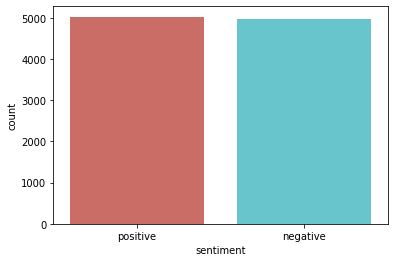

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot the number of positive or negative reviews
sns.countplot(x='sentiment', data=df, palette='hls')
plt.show()

## **Text preprocessing**
In order to prepare the text data for the model building we perform text preprocessing. It is the very first step of NLP projects. Some of the preprocessing steps are:

* Lower casing
* Removing Handles, URLs, Hashtags and Mentions
* Removing punctuations like . , ! $( ) * % @
* Removing Stop words
* Tokenization
* Stemming
* Lemmatization


### **Lower casing**
Lower casing provides a uniform base to our reviews but in some cases it could lead to loss of information.

Anyway, it's a basic step in NLP applications.

In [ ]:
df['review_lowercased'] = df['review'].apply(lambda x: x.lower())
df.head()

,review,sentiment,review_lowercased
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. <br /><br />the...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love in the time of money"" is..."


### Removing Handles, URLs, Hashtags and Mentions
As for tweets, reviews could contain handles, urls, mentions and stuff like that within them.
A basic preprocessing step consists of removing this kind of stuff.

In [ ]:
import re

def remove_handles_urls_hashtags_mentions(text):
  text = re.sub(r"/(?:https?|ftp):\/\/[\n\S]+/g", '', text) # remove links
  text = re.sub(r"/\#\w\w+\s?/g", '', text) # remove hashtags words
  text = text.replace('#', '') # remove hashtags only
  text = re.sub(r"/\@\w\w+\s?/g", '', text) # remove mentions
  text = re.sub(r"<.*?>", '', text) # remove html tag <br/>
  return text

# apply remove_handles_urls_hashtags_mentions to each review
df['clean_review'] = df['review_lowercased'].apply(lambda x: remove_handles_urls_hashtags_mentions(x))
df.head()

,review,sentiment,review_lowercased,clean_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. <br /><br />the...,a wonderful little production. the filming tec...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...,basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love in the time of money"" is...","petter mattei's ""love in the time of money"" is..."


* `r` The solution is to use Python’s raw string notation for regular expression patterns; backslashes are not handled in any special way in a string literal prefixed with 'r'
* `?` Causes the resulting RE to match 0 or 1 repetitions of the preceding RE. https? will match either ‘http’ or ‘https’.
* `https?:\/\/` will match any "http://" and "https://" in string
* `\S, \s` Returns a match where the string DOES NOT contain a white space character 
* `\w` Returns a matched word according to [a-zA-Z0-9]+
* `*` Zero or more occurrences
* `+` One or more occurrences

### **Punctuation Removal**
In this step, all the punctuations from the text are removed. `string` library of Python contains some pre-defined list of punctuations such as ‘!”#$%&'()*+,-./:;?@[\]^_`{|}~’

In order to accomplish this task, we build our function `remove_punctuation()`

In [ ]:
import string

def remove_punctuation(text):
  return "".join([word for word in text if word not in string.punctuation])

# apply remove_punctuation function to each review
df['clean_review'] = df['clean_review'].apply(lambda x: remove_punctuation(x))
df.head()

,review,sentiment,review_lowercased,clean_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. <br /><br />the...,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love in the time of money"" is...",petter matteis love in the time of money is a ...


### **Stopwords and Negations**
Stopwords are the commonly used words and are removed from the text as they do not add any value to the analysis. These words carry less or no meaning.

We load the stopwords list and remove from the list those we do not want to delete from the text. We do not remove negation words because reviews with a lot of these can indicate that the review has a negative sentiment.

In [ ]:
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

# negation stopwords
no_stopwords = ["not","don't",'aren','don','ain',"aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",
               'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't",
               "won't", 'wouldn', "wouldn't"]

# keep negation stopwords from stopwords set
for no_stopword in no_stopwords:
  stopwords.remove(no_stopword)

# Here's an example of English stopwords.
print(stopwords[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



We create a function to change negation abbreviate forms to standard using a regular expression.

In [ ]:
import re
re_negation = re.compile("n't ")

# function that receive a sequence of woords and return the same sequence transforming
# abbreviated negations to the standard form.
def negation_abbreviated_to_standard(text):
    text = re_negation.sub(" not ", text)
    return text

# apply negation_abbreviated_to_standard function to each review
df['review_fixed_negations'] = df['clean_review'].apply(lambda x: negation_abbreviated_to_standard(x))
df.head()

,review,sentiment,review_lowercased,clean_review,review_fixed_negations
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. <br /><br />the...,a wonderful little production the filming tech...,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...,basically theres a family where a little boy j...,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love in the time of money"" is...",petter matteis love in the time of money is a ...,petter matteis love in the time of money is a ...


### **Tokenization**
Word tokenization stands for splitting words from a sentence. Since we have several options to accomplish this task, we apply **Regular Expression** using `re` module.

In [ ]:
import re
def tokenization(text):
  tokens = re.split(r'\W+', text)
  return tokens

# apply tokenization function to each review
df['review_tokenized'] = df['review_fixed_negations'].apply(lambda x: tokenization(x))
df.head()

,review,sentiment,review_lowercased,clean_review,review_fixed_negations,review_tokenized
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,"[one, of, the, other, reviewers, has, mentione..."
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. <br /><br />the...,a wonderful little production the filming tech...,a wonderful little production the filming tech...,"[a, wonderful, little, production, the, filmin..."
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...,"[i, thought, this, was, a, wonderful, way, to,..."
3,Basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...,basically theres a family where a little boy j...,basically theres a family where a little boy j...,"[basically, theres, a, family, where, a, littl..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love in the time of money"" is...",petter matteis love in the time of money is a ...,petter matteis love in the time of money is a ...,"[petter, matteis, love, in, the, time, of, mon..."


### **Stopwords removal**
To remove stopwords (in English), download the `stopwords` package from NLTK library. Then, filter out stopwords from tokenized words. In order to remove stopwords, we write our function `remove_stopwords()`.





In [ ]:
def remove_stopwords(text):
  return [word for word in text if word not in stopwords]

# apply remove_stopwords function to each review
df['review_without_stopwords'] = df['review_tokenized'].apply(lambda x: remove_stopwords(x))
df.head()

,review,sentiment,review_lowercased,clean_review,review_fixed_negations,review_tokenized,review_without_stopwords
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,"[one, of, the, other, reviewers, has, mentione...","[one, reviewers, mentioned, watching, 1, oz, e..."
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. <br /><br />the...,a wonderful little production the filming tech...,a wonderful little production the filming tech...,"[a, wonderful, little, production, the, filmin...","[wonderful, little, production, filming, techn..."
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...,"[i, thought, this, was, a, wonderful, way, to,...","[thought, wonderful, way, spend, time, hot, su..."
3,Basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...,basically theres a family where a little boy j...,basically theres a family where a little boy j...,"[basically, theres, a, family, where, a, littl...","[basically, theres, family, little, boy, jake,..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love in the time of money"" is...",petter matteis love in the time of money is a ...,petter matteis love in the time of money is a ...,"[petter, matteis, love, in, the, time, of, mon...","[petter, matteis, love, time, money, visually,..."


### **Stemming**
**Stemming** refers to the process of slicing a word with the intention of 
removing affixes. 

For example, considering these words `[arguing, flies, playing, news]`, the corresponding stems are `[argu, fli, play, new]`.

In NLTK, this operation could be made simply using a _PorterStemmer_ object.
To stem a word, use the `stem()` function.

In [ ]:
from nltk.stem.porter import PorterStemmer

# define a PorterStemmer object
stemmer = PorterStemmer()

# define a function for stemming
def stemming(text):
  return [stemmer.stem(word) for word in text]

# apply stemming to each review
df['review_stemmed'] = df['review_without_stopwords'].apply(lambda x: stemming(x))
df.head()

,review,sentiment,review_lowercased,clean_review,review_fixed_negations,review_tokenized,review_without_stopwords,review_stemmed
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,"[one, of, the, other, reviewers, has, mentione...","[one, reviewers, mentioned, watching, 1, oz, e...","[one, review, mention, watch, 1, oz, episod, y..."
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. <br /><br />the...,a wonderful little production the filming tech...,a wonderful little production the filming tech...,"[a, wonderful, little, production, the, filmin...","[wonderful, little, production, filming, techn...","[wonder, littl, product, film, techniqu, unass..."
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...,"[i, thought, this, was, a, wonderful, way, to,...","[thought, wonderful, way, spend, time, hot, su...","[thought, wonder, way, spend, time, hot, summe..."
3,Basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...,basically theres a family where a little boy j...,basically theres a family where a little boy j...,"[basically, theres, a, family, where, a, littl...","[basically, theres, family, little, boy, jake,...","[basic, there, famili, littl, boy, jake, think..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love in the time of money"" is...",petter matteis love in the time of money is a ...,petter matteis love in the time of money is a ...,"[petter, matteis, love, in, the, time, of, mon...","[petter, matteis, love, time, money, visually,...","[petter, mattei, love, time, money, visual, st..."


### **Lemmatization**
**Lemmatization** has the objective of reducing a word to its base 
form, also called _lemma_, therefore grouping together different 
forms of the same word.
For example:
* `[Am, are, is]-> be`
* `[Car, cars, car’s, cars’] -> car`

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer

# download needed modules
nltk.download('wordnet')
nltk.download('omw-1.4')

# define a WordNet Lemmatizer object
lemmatizer = WordNetLemmatizer()

# define a function for lemmatization
def lemmatization(text):
  return [lemmatizer.lemmatize(word) for word in text]

# apply lemmatization function to each review
df['review_lemmatized'] = df['review_without_stopwords'].apply(lambda x: lemmatization(x))
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,review,sentiment,review_lowercased,clean_review,review_fixed_negations,review_tokenized,review_without_stopwords,review_stemmed,review_lemmatized
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,"[one, of, the, other, reviewers, has, mentione...","[one, reviewers, mentioned, watching, 1, oz, e...","[one, review, mention, watch, 1, oz, episod, y...","[one, reviewer, mentioned, watching, 1, oz, ep..."
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. <br /><br />the...,a wonderful little production the filming tech...,a wonderful little production the filming tech...,"[a, wonderful, little, production, the, filmin...","[wonderful, little, production, filming, techn...","[wonder, littl, product, film, techniqu, unass...","[wonderful, little, production, filming, techn..."
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...,"[i, thought, this, was, a, wonderful, way, to,...","[thought, wonderful, way, spend, time, hot, su...","[thought, wonder, way, spend, time, hot, summe...","[thought, wonderful, way, spend, time, hot, su..."
3,Basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...,basically theres a family where a little boy j...,basically theres a family where a little boy j...,"[basically, theres, a, family, where, a, littl...","[basically, theres, family, little, boy, jake,...","[basic, there, famili, littl, boy, jake, think...","[basically, there, family, little, boy, jake, ..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love in the time of money"" is...",petter matteis love in the time of money is a ...,petter matteis love in the time of money is a ...,"[petter, matteis, love, in, the, time, of, mon...","[petter, matteis, love, time, money, visually,...","[petter, mattei, love, time, money, visual, st...","[petter, matteis, love, time, money, visually,..."


Since in the `lemmatize()` function we don't pass any POS tag, the default option is 'noun'. This explains the results.  

Lemmatization is preferred for context analysis, whereas stemming is recommended when the context is not important.

Since all preprocessing steps are completed, for sake of semplicity let us store the processed reviews into a DataFrame column called 'review_processed'. 

All the preprocessing step are put together in order to build a preprocessing function called `preprocess_review(review)` which takes as input a review and returns a preprocessed review.
This function will be useful later.

In [ ]:
df['review_processed'] = df['review_stemmed']

def preprocess_review(review):
  '''
    input:
      review: raw text
    output:
      processed_review: text after preprocessing
  '''

  # remove punctuation and lowercasing
  review = remove_punctuation(review).lower()

  # remove handles and urls
  review = remove_handles_urls_hashtags_mentions(review)
  
  # fix negations
  review = negation_abbreviated_to_standard(review)

  # tokenize reviews into words
  review = tokenization(review)

  # remove admitted stopwords
  review = remove_stopwords(review)

  # stemming words
  review = lemmatization(review)
  
  return review

## **Vocabulary, Text Representation and Feature Extraction**
In NLP and ML, it is mandatory to encode text data into a suitable 
numerical form. This conversion from raw text to a suitable numerical form is called **text representation**.

There are a variety of approaches, depending both by the task to 
be addressed and the model to be employed
* Basic vectorization approaches
* Distributed representation


### **Distributed representation and Word Embedding**
Distributed representation schemes significantly compress the 
dimensionality:
1. This results in vectors that are 
compact and dense
2. Based on the distributional hypothesis from linguistics
3. Words that occur in similar contexts have similar meanings. This means that the corresponding 
representation vectors must be close to each other.


**Word Embedding** is based on a language modeling technique used for mapping words to vectors of real numbers. It represents words or phrases in vector space with several dimensions. 

Each discrete word is *embedded* in a continuous vector space. 

#### **TF-IDF Vectorization**
**Term frequency-inverse document frequency** is a text vectorizer that transforms the text into a usable vector. It combines 2 concepts, Term Frequency (TF) and Document Frequency (DF).

The **term frequency** is the number of occurrences of a specific term in a document. Term frequency indicates how important a specific term in a document. Term frequency represents every text from the data as a matrix whose rows are the number of documents and columns are the number of distinct terms throughout all documents.

**Document frequency** is the number of documents containing a specific term. Document frequency indicates how common the term is.

**Inverse document frequency** (IDF) is the weight of a term, it aims to reduce the weight of a term if the term’s occurrences are scattered throughout all the documents. IDF can be calculated as follow:

$$ idf_i = \log (\frac{n}{df_i})$$

* $ idf_i $ is the IDF score for term $i$
* $ df_i $ is the number of documents containing term $i$
* $n$ is the total number of documents. 

The higher is the DF score of a term, the lower is the IDF score for the term. When the number of DF is equal to n which means that the term appears in all documents, the IDF will be zero, since log(1) is zero, when in doubt just put this term in the stopword list because it doesn't provide much information.

The **TF-IDF score** as the name suggests is just a multiplication of the term frequency matrix with its IDF, it can be calculated as follow:

$$ w_{i,j} = tf_{i,j} \times idf_i $$

* $ w_{i,j} $ is TF-IDF score for term $i$ in document $j$
* $ tf_{i,j} $ is term frequency for term $i$ in document $j$
* $ idf_i $ is IDF score for term $i$.


In [ ]:
# import tf-idf encoding from sklearn library
from sklearn.feature_extraction.text import TfidfVectorizer

# define some hyperparameters of encoded
vectorizer = TfidfVectorizer(max_features=300, ngram_range = (1,2))

#### **Word2Vec**
**Word2vec** (Mikolov et al. 2013) is a framework for learning word vectors and it consists of models for generating word embedding. 
We generate word vectors through a CBOW approach using `gensim` Python module (as a black-box).

In [ ]:
import gensim
import multiprocessing

cores = multiprocessing.cpu_count()

# create W2V model(CBOW approach) trained on processed reviews
w2v = gensim.models.Word2Vec(df['review_processed'], size=300, min_count=1, workers=cores, iter=20)

print(f"There are {len(w2v.wv.vocab)} unique words in our vocabulary.")

# get the vocabulary (dict{'word': word embedding})
vocabulary = {}
for idx, key in enumerate(w2v.wv.vocab):
  vocabulary[key] = w2v.wv[key]

# convert vocabulary to dataframe just for visualization aim
v = pd.DataFrame(vocabulary).transpose()
print(v.shape)
v.head()

There are 62929 unique words in our vocabulary.
(62929, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
one,-0.278704,-1.563614,1.139554,-0.197034,1.501390,0.262904,0.785641,-1.089939,-1.013865,-0.805042,...,0.478685,-0.700915,-0.155109,-0.383775,2.065877,0.172321,0.194025,0.918674,-1.995149,-0.842337
review,0.474472,-0.005320,0.148690,-0.385341,0.845563,-2.262778,1.146722,1.210013,-1.362287,0.955019,...,0.062029,0.683448,1.213118,1.190191,0.569532,1.413192,-0.897810,1.323548,-1.845526,0.069348
mention,0.814110,-0.182266,-0.299170,-1.848381,0.317799,0.526488,-0.978933,0.770999,-0.420234,-0.169382,...,-0.829784,-0.497386,-0.388510,1.220574,1.191224,0.994207,-0.105006,1.493413,-1.052595,0.641458
watch,-1.137781,0.829097,0.116663,-1.242733,0.798733,-0.498068,0.897103,1.404434,-0.513425,1.117851,...,0.803895,0.499530,0.081233,-0.739808,0.860170,1.417792,0.925506,-0.368589,-2.520628,-0.078706
1,-0.761739,1.104425,-0.449793,-1.181986,0.358797,-0.359382,0.050549,0.388696,-0.607834,0.532001,...,-0.456142,0.987659,-2.321114,-1.019198,1.082629,0.418107,0.221155,0.406645,-1.458608,-1.686240


Using a Word2Vec model, we could easily show the most similar words due to the cosine similarity between vectors.
Let us suppose that we want to know the most similar words for the word `horrible`. Just recall the function `most_similar()` passing as parameter the interested word.

In [ ]:
w2v.wv.most_similar(['watch'])

[('rent', 0.5186030864715576),
 ('see', 0.47203171253204346),
 ('sit', 0.4671359956264496),
 ('recommend710', 0.4516254663467407),
 ('moni', 0.4379575848579407),
 ('sat', 0.4365718364715576),
 ('attherefor', 0.42980748414993286),
 ('check', 0.4242485463619232),
 ('itonc', 0.4174768328666687),
 ('honestli', 0.41246795654296875)]

As we can see, there're some unmeaningful words like `awfulnessthe ` since the W2V model is trained on our reviews. When training a model like this, it's really relevant that the input text is adequately preprocessed in order to filter out unmeaningful words as in this case.

#### **Getting Review embeddings**
Since we got our vocabulary that connects each word to the corresponding word embedding obtained from the Word2Vec trained model, we could get the review embedding simply summing up the corresponding word embeddings associated to the words of the review.

In [ ]:
import numpy as np
def get_review_embedding(review, vocabulary):
    '''
    Input:
        - review: a string
        - vocabulary: a dictionary of word embeddings
    Output:
        - rev_embedding: sum of all word embeddings in the tweet
    '''
    rev_embedding = np.zeros(300) # length of a word embedding

    for word in review:
        # add the word embedding to the running total for the document embedding
        rev_embedding += vocabulary.get(word,0)    
    return rev_embedding

# apply get_review_embedding to each review
df['rev_embedding'] = df['review_processed'].apply(lambda x: get_review_embedding(x, vocabulary)).apply(lambda x: np.array(x))
df.head()

,review,sentiment,review_lowercased,clean_review,review_fixed_negations,review_tokenized,review_without_stopwords,review_stemmed,review_lemmatized,review_processed,rev_embedding
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,"[one, of, the, other, reviewers, has, mentione...","[one, reviewers, mentioned, watching, 1, oz, e...","[one, review, mention, watch, 1, oz, episod, y...","[one, reviewer, mentioned, watching, 1, oz, ep...","[one, review, mention, watch, 1, oz, episod, y...","[45.778782200068235, -6.56397203495726, 38.567..."
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. <br /><br />the...,a wonderful little production the filming tech...,a wonderful little production the filming tech...,"[a, wonderful, little, production, the, filmin...","[wonderful, little, production, filming, techn...","[wonder, littl, product, film, techniqu, unass...","[wonderful, little, production, filming, techn...","[wonder, littl, product, film, techniqu, unass...","[5.844898314215243, -11.917749622371048, 9.063..."
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...,"[i, thought, this, was, a, wonderful, way, to,...","[thought, wonderful, way, spend, time, hot, su...","[thought, wonder, way, spend, time, hot, summe...","[thought, wonderful, way, spend, time, hot, su...","[thought, wonder, way, spend, time, hot, summe...","[9.796419971738942, -20.91012138564838, 13.341..."
3,Basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...,basically theres a family where a little boy j...,basically theres a family where a little boy j...,"[basically, theres, a, family, where, a, littl...","[basically, theres, family, little, boy, jake,...","[basic, there, famili, littl, boy, jake, think...","[basically, there, family, little, boy, jake, ...","[basic, there, famili, littl, boy, jake, think...","[4.008867487544194, -18.149562894832343, -12.5..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love in the time of money"" is...",petter matteis love in the time of money is a ...,petter matteis love in the time of money is a ...,"[petter, matteis, love, in, the, time, of, mon...","[petter, matteis, love, time, money, visually,...","[petter, mattei, love, time, money, visual, st...","[petter, matteis, love, time, money, visually,...","[petter, mattei, love, time, money, visual, st...","[27.803720200667158, -32.381350580602884, 28.0..."


This is a possible solution to get review embeddings. A valid alternative is given by training a **Doc2Vec** model (Mikolov et al. 2014) using `gensim.models.Doc2Vec`,  which is an extension of word2vec that uses paragraph vectors as part of the context during training.

---

## **Metrics**
In order to assess the performance of a machine learning model, there are some particular metrics like accuracy, precision, recall and F-score.
This information can be graphically summarized into a confusion matrix. 

First of all, let introduce the basic concepts.

* **True positive (tp)**: the model correctly predicts the positive class; 
* **True negative (tn)**: the model correctly predicts the negative class;
* **False positive (fp)**: the model incorrectly predicts the positive class;
* **False negative (fn)**: the model incorrectly predicts the negative class.



### **Accuracy**
Accuracy measures how close a given set of measurements (observations or readings) are to their true value. Basically, the ratio of the number of correct predictions to the number of total predictions.

$$ \text{accuracy} = \frac{tp+tn}{tp+tn+fp+fn} $$



### **Precision**
The *precision* is intuitively the ability of the classifier not to label a negative sample as positive. It's given by the ratio of true positives to the sum between true positives and false positives.

$$ \text{precision} = \frac {\text{true positives}}{\text{true positives + false positives}}$$



### **Recall**
The *recall* is intuitively the ability of the classifier to find all the positive samples. It's given by the ratio of true positives to the sum between true positives and false negatives.

$$ \text{recall} = \frac {\text{true positives}}{\text{true positives + false negatives}}$$



### **F-score**
The *F-beta score* can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights recall more than precision by a factor of `beta`. 

`if beta == 1.0: =>` recall and precision are equally important.

$$ F_1 = \frac{2PR}{P+R} = 2\frac{\frac{tp}{tp+fp}\frac{tp}{tp+fn}}{\frac{tp}{tp+fp} + \frac{tp}{tp+fn}}$$

* $P$ stands for precision
* $R$ stands for recall


### **Confusion matrix**
By definition a *confusion matrix* $C$ is such that $C_{i,j}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$.

Thus in binary classification, the count of true negatives is $C_{0,0}$, false negatives is  $C_{0,1}$, true positives is $C_{1,1}$and false positives is $C_{1,0}$. In this case, we're referring to a **2-by-2 confusion matrix**. Examples of confusion matrices will be shown later in the document.

### **Building a function that collects these measures**


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd

def collect_measures(y_tests, y_preds):
  '''
    input:
      y_tests: list of y_test (test set associated to the binary classification)
      y_preds: list of y_pred (prediction set associated to the binary classification)
    output:
      df: 2x4 matrix that has ['avg_measures', 'std_measures'] as rows and ['accuracy', 'precision', 'recall', 'f1_score'] as columns

  '''
  accuracies = [accuracy_score(y_test, y_pred) for y_test, y_pred in zip(y_tests, y_preds)]
  precisions = [precision_score(y_test, y_pred, pos_label='positive') for y_test, y_pred in zip(y_tests, y_preds)]
  recalls = [recall_score(y_test, y_pred, pos_label='positive') for y_test, y_pred in zip(y_tests, y_preds)]
  fscores = [f1_score(y_test, y_pred, pos_label='positive') for y_test, y_pred in zip(y_tests, y_preds)]

  measurements = np.array([accuracies, precisions, recalls, fscores])
  
  avg_measurements = [np.mean(measurement) for measurement in measurements]
  std_measurements = [np.std(measurement) for measurement in measurements]

  df = pd.DataFrame([avg_measurements, std_measurements], columns=['accuracy', 'precision', 'recall', 'f1_score'], index=['avg_measurements', 'std_measurements'])
  return df

---

## **Logistic Regression**
Logistic regression is a machine learning model that uses a hyperplane in an $m$ dimensional space to separate data points with $m$ number of features into their classes.

The function that quantifies errors in this model is called a **cross-entropy loss function**. Therefore, a model would try to minimize the value of the loss function as possible, using an optimization algorithm such as the **Stochastic Gradient Descent**.


### **Multivariate Linear Regression Problem**
Given a training set $D$ denoted as:
$$ \{(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \dots,(x^{(m)}, y^{(m)})\}$$
where:
* $x$ is a set of **pattern vectors** of the training set $D$
* $y$ is the **class associated to each pattern vector**, such that $ y^{(i)} \in [0, 1]$, due to the binary classification problem,

a **Multivariate Linear Regression problem** is defined when the number of features of each pattern $x^{(i)}$ in our training set $D$ is greater than $1$, such that each pattern is an $m$ dimensional vector $ x^{(i)} \in ℝ^m $ where $m \ge 2 $, denoted as follows: 

$$ x^{(i)} = [x_0^{(i)}, x_1^{(i)}, \dots, x_m^{(i)} ] \in ℝ^{m} $$

where $ x_0^{(i)} = 1$  $\forall i$

Since we are looking for a Multivariate Linear Regression model, the **parameters vector** $\theta$ is denoted as:

$$ \theta = [\theta_0, \dots, \theta_m ] \in ℝ^{m} $$

where $ \theta_0 $ is called **bias**, also denoted with $b$. 

A **Multivariate Linear Regression model** is simply a hyperplane in an $m$ dimensional space, such that:

$$ \left ( \sum_{j=1}^{m} \theta_jx_j^{(i)} \right ) + b = \theta \cdot x^{(i)} + b$$

which could be also expressed as:

$$ \sum_{j=0}^{m} \theta_jx_j^{(i)} =  \theta \cdot x^{(i)} = \theta^Tx^{(i)}$$

* the equation $ \sum_{j=0}^{m} \theta_jx_j^{(i)} = 0 $ is the equation of a **hyperplane** (a generalization of a line to N dimensions).
* when the expression $ \sum_{j=0}^{m} \theta_jx_j^{(i)} > 0$ is thus the part of N-dimensional space above this hyperplane. 

Thus we can see the logistic regression function as learning a hyperplane which separates points in space which are in the class (’true’ or 1) from points which are not in the class.






### **Logistic Function**
Since we are dealing with a **Multivariate Logistic Regression model**,
we introduce the **logistic function** (for this, logistic regression), which maps values from  $-\infty$ and $+\infty$ to lie between 0 and 1, in such a way that the output of the linear regression model could be seen as the probability of being in a positive or negative class. 

A logistic function (or sigmoid function) is denoted as:

$$ S(x) = \frac{1}{1+e^{-x}}$$

that, applied in our case, becomes:

$$ h(\theta^Tx^{(i)}) = \frac{1}{1+ e^{-\theta^Tx^{(i)}}} \Rightarrow P(y = true \mid x^{(i)})$$

Here it is an example plot of the logistic function. 


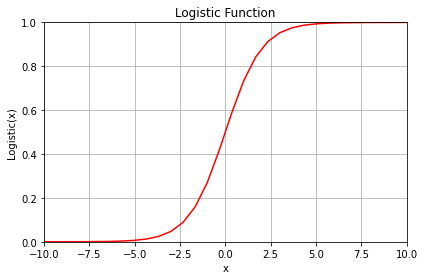

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams["figure.autolayout"] = True

def logistic(x):
   return 1 / (1 + np.exp(-x))

x = np.linspace(-100, 100, 300)

plt.plot(x, logistic(x), color='red')
plt.xlabel("x")
plt.xlim(-10, 10)
plt.ylabel("Logistic(x)")
plt.ylim(0,1)
plt.title("Logistic Function")
plt.grid()
plt.show()


### **Cross-Entropy Loss**
Since we are dealing with a learning problem, we need a **Cost Function** (also called loss function), which simply quantifies the error between predicted and expected values.

In linear regression, learning consisted of choosing the weights $\theta$ which minimized the sum-squared error on the training set. So, the linear regression cost function was denoted as: 

$$ J(\theta) = \frac{1}{2m} \sum_{i=0}^{m} (h(x^{(i)}, \theta) - y^{(i)})^2 $$

Since we are using a logistic function, the linear regression cost function becomes a non-linear and non-convex function. 

However, in order to fix this problem, we consider the **binary cross-entropy loss**, which is a case of **conditional maximum likelihood estimation**, which consists of choosing the parameters $\theta$ which makes the probability of the observed $y$ values in the training data to be the highest, given the observations $x$.

Since there are only 2 discrete outcomes (0 or 1) we can express 
the probability $p(y\mid x)$ from our classifier as:

$$ p(y|x) = \hat{y}^y(1-\hat{y})^{1-y}$$

where $\hat{y}$ is the predicted class.

Note that:
* if $y = 0$, this simplifies to $\hat{y}$
* if $y = 1$, this simplifies to $1 - \hat{y}$

So, taking the log of both sides, we get:

$$\log p(y|x) = \log [\hat{y}^y(1-\hat{y})^{1-y}] $$

$$ = y \log \hat{y} + (1-y) \log(1-\hat{y}) $$

Since:
* $\hat{y}$ corresponds to $h(x^{(i)}; \theta)$ and $y$ corresponds to $y^{(i)}$
* the **cross-entropy loss** corresponds to the **negative of the natural logarithm of the maximum log-likelihood**,

we get that the cross-entropy loss $L_{CE}$ is given by:


$$  
\begin{equation}
L_{CE}(h(x^{(i)}; \theta), y^{(i)}) = \begin{cases}
  -\log (h(x^{(i)}; \theta) & \text{if } y^{(i)} = 1 \\
  -\log (1 - h(x^{(i)}; \theta) & \text{if } y^{(i)} = 0
\end{cases}
\end{equation}  
$$

Since $y^{(i)} \in [0,1], \forall i$:

$$ L_{CE} = - y^{(i)}\log (h(x^{(i)}; \theta)) - (1-y^{(i)})\log (1 - h(x^{(i)}; \theta)) $$




### **Gradient Descent method**

Considering explicitly the cross-entropy function parameterized by the weights $\theta$, we want the weights that minimize the loss, averaged over all 
observations:

$$ \hat{\theta} = \underset{\theta}{\arg\min} \frac{1}{m}\sum_{i = 0}^m L_{CE}(h(x^{(i)}; \theta), y^{(i)}) $$

$$ = \underset{\theta}{\arg\min} \left [ -\frac{1}{m}\sum_{i = 0}^m y^{(i)}\log (h(x^{(i)}; \theta)) + (1-y^{(i)})\log (1 - h(x^{(i)}; \theta)) \right]$$

Since the cross-entropy loss function is **convex**, so it has just a global minimum, it is used the **Gradient Descent method** as optimization algorithm, in order to update the parameters $\theta$.

The **idea** behind Gradient Discent is **to find the gradient of the loss 
function at the current point and move in the opposite direction**.
Note that, since the gradient points to the direction of the maximum variation, moving in the opposite direction of the gradient is a clever idea to find the minimum. 

It is **guaranteed** that Gradient descent starting from any point will find the minimum.

$$ \theta^{t+1} = \theta^t - \eta \frac{d}{d\theta}L_{CE}(h(x;\theta), y)$$

* $\eta$ is the learning rate;
* $\frac{d}{d\theta}L_{CE}(h(x;\theta), y)$ is the value of the gradient

### **Building a Logistic Regression model**
A LR model can be built using `sklearn` package. We repeat the experiment 30 times in order to assess the robustness of the model, in terms of statistical criteria like mean and standard deviation of the accuracies reported at each epoch. So, the model will be trained by using a different data splitting at each epoch.


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

# number of iterations also called epochs
epochs = 30

y_tests = []
y_preds = []

# repeat this process for several epochs
for i in tqdm_notebook(range(epochs), "Wait till the end of the epochs...\n"):
  # splitting review embeddings into training set and test set (0.8-0.2)
  X_train, X_test, y_train, y_test = train_test_split(df['rev_embedding'], df['sentiment'], test_size=0.2, shuffle=True)

  # initialize a Logistic Regression model 
  model = LogisticRegression(max_iter=500)

  # train the model
  model.fit(list(X_train), list(y_train))

  # get predictions
  y_preds.append(model.predict(list(X_test)))
  y_tests.append(y_test)


# print an example of classification report for the last model (precision, recall, F1-score, support)
print("Here it is an example of classification report for the last model")
print(classification_report(y_tests[-1], y_preds[-1], target_names=['positive', 'negative']))

# print measures for the model (using the test dataset and the corresponding predictions)
measures = collect_measures(y_tests, y_preds)
print(measures)


Wait till the end of the epochs...
:   0%|          | 0/30 [00:00<?, ?it/s]

Here it is an example of classification report for the last model
              precision    recall  f1-score   support

    positive       0.88      0.84      0.86       997
    negative       0.85      0.89      0.87      1003

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000

                  accuracy  precision    recall  f1_score
avg_measurements  0.854817   0.848131  0.864223  0.856044
std_measurements  0.008434   0.010416  0.012480  0.009074


Since the standard deviation for each measure is a small number, we can conclude that the model performs well. 

Above, it's also displayed the classification report referred to the last LR model. 

Text(0.5, 1.0, 'Confusion matrix Logistic Regression')

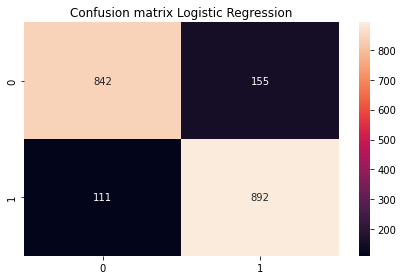

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# get confusion matrix for the last model
confusion_matrix_logistic_regression = confusion_matrix(y_tests[-1], y_preds[-1])

# plot the confusion matrix
ax = plt.axes()
sns.heatmap(confusion_matrix_logistic_regression, annot=True, fmt="d")
ax.set_title('Confusion matrix Logistic Regression')

### **Testing the LR model...**

In [ ]:
import numpy as np
# show an example of prediction 
example = input(prompt="Type an example of review: ")
# preprocess the review
review_processed = preprocess_review(example)

print(review_processed)

rev_embedding = get_review_embedding(review_processed, vocabulary)
print(model.predict([rev_embedding]))

Type an example of review: This film was bad
['film', 'bad']
['negative']


---

## **Naive Bayes**
Naive Bayes methods are a set of supervised learning algorithms based on applying **Bayes’ theorem** with the **“naive” assumption of conditional independence** between every pair of features given the value of the class variable.


### **Assumptions of Naive Bayes**
* All the variables are independent. 
* All the predictors have an equal effect on the outcome.


### **Bayes' Theorem and Naive Conditional Independence Assumption**
**Bayes’ theorem** states the following relationship, given class variable $y$ and dependent feature vector $x_1$ through $x_n$, :

$$P(y \mid x_1, \dots, x_n) = \frac{P(x_1, \dots, x_n \mid y) P(y)}
                                 {P(x_1, \dots, x_n)}$$

where:
* $P(y \mid x_1, \dots, x_n)$ is called **a-posteriori probability**;
* $P(x_1, \dots, x_n \mid y) $ is the **likelihood**;
* $P(y)$ is the **prior probability**;
* $ P(x_1, \dots, x_n) $ is called **evidence**.


Using the **naive conditional independence assumption** that

$$P(x_1, \dots, x_n \mid y) = P(x_1 \mid y) \dots P(x_n \mid y)$$

for all $i$, this relationship is simplified to

$$P(y \mid x_1, \dots, x_n) = \frac{P(y) \prod_{i=1}^{n} P(x_i \mid y)}
{P(x_1, \dots, x_n)}$$

### **Maximum A Posteriori Estimation**
Since $P(x_1, \dots, x_n)$ is constant given the input, we can use the following classification rule:

$$ \begin{align}\begin{aligned}P(y \mid x_1, \dots, x_n) \propto P(y) \prod_{i=1}^{n} P(x_i \mid y)\\\\\ \Rightarrow \hat{y} = \arg\max_y P(y) \prod_{i=1}^{n} P(x_i \mid y),\end{aligned}\end{align}$$

and we can use **Maximum A Posteriori (MAP) estimation** to estimate $P(y)$ and $P(x_i \mid y)$; the former is then the relative frequency of class $y$ in the training set.

### **Building a Naive Bayes model**
As we did for logistic regression, a Naive Bayes model can be built using `sklearn` package.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

y_tests = []
y_preds = []

# repeat this process for several epochs
for i in tqdm_notebook(range(epochs), "Wait till the end of the epochs..."):
  # splitting review embeddings into training set and test set (0.8-0.2)
  X_train, X_test, y_train, y_test = train_test_split(df['review_processed'], df['sentiment'], test_size=0.2, shuffle=True)

  # detokenize reviews since vectorizer.fit_transform takes text, not tokens
  X_train = [" ".join([word for word in review]) for review in X_train]
  X_test = [" ".join([word for word in review]) for review in X_test]

  X_train = vectorizer.fit_transform(X_train).toarray()
  X_test = vectorizer.transform(X_test).toarray()

  # initialize a Gaussian Naive Bayes classifier
  model = GaussianNB()

  # train the model
  model.fit(X_train, y_train)

  # get predictions
  y_preds.append(model.predict(X_test))
  y_tests.append(y_test)


# print an example of classification report for the last model (precision, recall, F1-score, support)
print("Here it is an example of classification report for the last model")
print(classification_report(y_tests[-1], y_preds[-1], target_names=['positive', 'negative']))

# print measures for the model (using the test dataset and the corresponding predictions)
measures = collect_measures(y_tests, y_preds)
print(measures)


Wait till the end of the epochs...:   0%|          | 0/30 [00:00<?, ?it/s]

Here it is an example of classification report for the last model
              precision    recall  f1-score   support

    positive       0.76      0.76      0.76       975
    negative       0.78      0.78      0.78      1025

    accuracy                           0.77      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.77      0.77      0.77      2000

                  accuracy  precision    recall  f1_score
avg_measurements  0.782283   0.778627  0.794615  0.786450
std_measurements  0.007297   0.012790  0.009946  0.007879


Also in this case, since the standard deviation for each measure is a small number, we can conclude that the model performs well. 

Above, it's also displayed the classification report referred to the last NB model. 

Text(0.5, 1.0, 'Confusion matrix Naive Bayes')

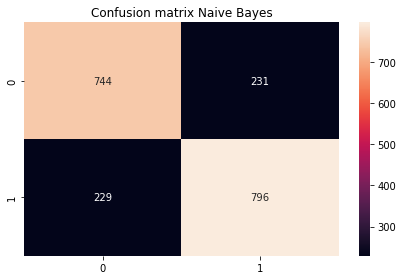

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# get confusion matrix for the last model
confusion_matrix_naive_bayes = confusion_matrix(y_tests[-1], y_preds[-1])

# plot the confusion matrix
ax = plt.axes()
sns.heatmap(confusion_matrix_naive_bayes, annot=True, fmt="d")
ax.set_title('Confusion matrix Naive Bayes')

### **Testing the NB model...**

In [ ]:
import numpy as np
# show an example of prediction 
example = input(prompt="Type an example of review: ")
# preprocess the review
review_processed = preprocess_review(example)
print(review_processed)

review_processed = [" ".join([word for word in review_processed])]
tf_idf_vector =  vectorizer.transform(review_processed).toarray()
print(model.predict(tf_idf_vector))

Type an example of review: Breaking  bad is the best tv series i've ever seen
['breaking', 'bad', 'best', 'tv', 'series', 'ive', 'ever', 'seen']
['positive']
